# Lab 3 - Batch Normalization

This lab has the following goals:
a) Implement functional and module based batch normalization layer b) Understand the subtleties regarding batchnorm usage, particularly avoiding statistic computation in the test set c) Introduce the use of `register_buffer` in `torch.nn.Module` d) Understand the `.eval()` and `.train()` methods of `torch.nn.Module` and what these do. It is recommended to run the lab mini-experiments on GPU.


## 0 Initialization

Run the code cells below to initialize the train and test loaders of the MNIST dataset and visualize one of the MNIST samples.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets,transforms


# Initialize train and test datasets
train_set = datasets.MNIST('../data',
                           train=True,
                           download=True,
                           transform=transforms.ToTensor())
test_set = datasets.MNIST('../data',
                          train=False,
                          download=True,
                          transform=transforms.ToTensor())

# Initialize train and test data loaders
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=256,
                                           shuffle=True,
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=256,
                                          shuffle=True,
                                          drop_last=True)

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw


Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw
Processing...


c:\program files\python37\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!






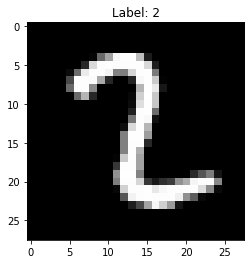

In [2]:
# Visualize a sample from MNIST
X_train_samples, y_train_samples = next(iter(train_loader))
plt.title(f'Label: {y_train_samples[0]}')
plt.imshow((X_train_samples[0].squeeze(0)).numpy(), cmap='gray');

## 1 Functional Batch Normalization

### 1.1 Batch Normalization Function
Implement a function that performs batch normalization on a given `inputs` tensor of shape `(N, F)`, where `N` is the minibatch size and `F` is the number of features. Note that batch normalization performs differently at train and inference time:
* `train`: During training, batch normalization standardizes the given inputs along the minibatch dimension (mean and standard deviation would be of shape `(F,)`). The running average of the minibatch means and variances are updated during training. Learnable parameters $\beta$ and $\gamma$ shift and scale the distribution after standardization.
* `eval`: During evaluation (inference), batch normalization uses the running average of the means and standard deviations which were computed during training for normalization.

Implement a functional batch normalization layer with the differentiable affine parameters $\gamma$ and $\beta$. The batch normalization layer has the following formulation:

$$y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$


You will need to create an additional set of variables to track and update the statistics (`toy_stats_dict`). Note that the statistics are updated outside of backpropagation. For the momentum rate of batchnorm statistics use `0.1`.

Your function is then checked in train mode with 100 sample random values $\sim \mathcal{N}(50,10)$ (so shape would be `(100, 1)`. The correct printed output should be (very close to):

    Training Samples
    Before BN: mean tensor([54.8908]), var tensor([8.1866])
    After BN: mean tensor([-1.3208e-06], grad_fn=<MeanBackward1>), var tensor([0.9999], grad_fn=<VarBackward1>)


In [30]:
import torch
from torch import nn

# Set seed
torch.manual_seed(691)

# Number of features
train_size = 500
test_size = 1
num_features = 1

# Generates toy train features for evaluating your function down below
toy_train_features = (torch.rand(train_size, num_features) * 10) + 50
# print(toy_train_features)

### TODO: Initialize the `running_mean` and `running_var` variables
### with 0 and 1 values respectively.
toy_stats_dict = {
    "running_mean": 0,
    "running_var": 1,
}

### TODO: Initialize the learnable parameters `beta` and `gamma` 
### with 0 and 1 values respectively.
beta = 0
gamma = 1

import torch
from torch import nn

def batchnorm(inputs,  beta,gamma, stats_dict,train=True, eps=0.001, momentum=0.1):
    # Use `is_grad_enabled` to determine whether the current mode is training
    # mode or prediction mode
    moving_mean=stats_dict["running_mean"]
    moving_var=stats_dict["running_var"]
    if not train:
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        inputs_hat = (inputs - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        print(len(inputs.shape))
        assert len(inputs.shape) in (2, 4)
        if len(inputs.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = inputs.mean(dim=0)
            var = ((inputs - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = inputs.mean(dim=(0, 2, 3), keepdim=True)
            var = ((inputs - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        inputs_hat = (inputs - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = torch.tensor(gamma * inputs_hat + beta,requires_grad=True)  # Scale and shift
   
    return Y


# run batchnorm on toy train features
bn_out_train = batchnorm(toy_train_features, beta, gamma, toy_stats_dict)
# print(bn_out_train)
# print results
print("Training Samples")
print(f"Before BN: mean {toy_train_features.mean(0)}, var {toy_train_features.var(0)}")
print(f"After BN: mean {bn_out_train.mean(0)}, var {bn_out_train.var(0)}\n")

2
Training Samples
Before BN: mean tensor([54.8908]), var tensor([8.1866])
After BN: mean tensor([-2.6489e-06], grad_fn=<MeanBackward1>), var tensor([1.0019], grad_fn=<VarBackward1>)



c:\program files\python37\lib\site-packages\ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### 1.2 Setting up the Model Arhitecture
For the model architecture, we use the 2 layer model from previous labs (the one that doesnt use `nn.Module`) and use the batchnorm function defined in part (1.1) (without the batchnorm parameters) at the 2 hidden layers.

In [37]:
# Initialize model hiden layer sizes
h1_size = 50
h2_size = 50

### TODO: Initialize the beta and gamma parameters
beta0 = 0
gamma0 = 1
beta1 = 0
gamma1 = 1

# Intentional naive initialization (do not modify)
param_dict = {
    "W0": torch.rand(784, h1_size)*2-1,
    "b0": torch.rand(h1_size)*2-1,    
    "W1": torch.rand(h1_size, h2_size)*2-1,
    "b1": torch.rand(h2_size)*2-1,    
    "W2": torch.rand(h2_size,10)*2-1,
    "b2": torch.rand(10)*2-1,
}
for name, param in param_dict.items():
#     param_dict[name] = param.to(device)
    param_dict[name] = param
    param.requires_grad=True
param_dict["beta0"]= beta0
param_dict["beta1"]= beta1
param_dict["gamma0"]= gamma0
param_dict["gamma1"]= gamma1
### TODO: Initialize the `running_mean` and `running_var` variables
### with 0s and 1s respectively.
l1_stats_dict = {
    "running_mean": 0,
    "running_var": 1,
}
l2_stats_dict = {
    "running_mean": 0,
    "running_var": 1,
}
layers_stats_list = [l1_stats_dict, l2_stats_dict]

def my_nn(input, param_dict, layers_stats_list, train=True):
    r"""Performs a single forward pass of a 2 layer MLP with batch 
    normalization using the given parameters in param_dict and the
    batch norm statistics in layers_stats_list.

    Args:
        input (torch.tensor): Batch of images of shape (N, H, W), where N is 
            the number of input samples, and H and W are the image height and 
            width respectively.
        param_dict (dict of torch.tensor): Dictionary containing the parameters
            of the neural network. Expects dictionary keys to be of format 
            "W#", "b#", "beta#" and "gamma#" where # is the layer number.
        layers_stats_list (list of dict of torch.tensor): List of dictionaries
            containing running means and variances for each layer. List size 
            is equal to the number of hidden layers.
        train (bool): Determines whether batch norm is in train mode or not.
            Default: True

    Returns:
        torch.tensor: Neural network output of shape (N, 10)
    """
    x = input.view(-1, 28*28) 

    # layer 1
    x = torch.relu_(x @ param_dict['W0'] + param_dict['b0'])

    ### TODO: use your complete batchnorm function
    x = batchnorm(x, beta0, gamma0, l1_stats_dict)

    # layer 2
    x = torch.relu_(x @ param_dict['W1'] + param_dict['b1'])

    ### TODO: use your complete batchnorm function
    x = batchnorm(x, beta1, gamma1, l2_stats_dict)
    # output 
    x = x @ param_dict['W2'] + param_dict['b2']
    return x

def my_zero_grad(param_dict):
    r"""Zeros the gradients of the parameters in `param_dict`.

    Args:
        param_dict (dict of torch.tensor): Dictionary containing the parameters
            of the neural network. Expects dictionary keys to be of format 
            "W#", "b#", "beta#" and "gamma#" where # is the layer number.
        layers_stats_list (list of dict of torch.tensor): List of dictionaries
            containing running means and variances for each layer. List size 
            is equal to the number of hidden layers.

    Returns:
        None
    """
    for _, param in param_dict.items():
        if param.grad is not None: 
            param.grad.detach_()
            param.grad.zero_()

            
def initialize_nn(param_dict, layers_stats_list):
    r"""Initializes the parameters in `param_dict` and resets the statistics
    in `layers_stats_list`.

    Args:
        param_dict (dict of torch.tensor): Dictionary containing the parameters
            of the neural network. Expects dictionary keys to be of format 
            "W#", "b#", "beta#" and "gamma#" where # is the layer number.
        layers_stats_list (list of dict of torch.tensor): List of dictionaries
            containing running means and variances for each layer. List size 
            is equal to the number of hidden layers.

    Returns:
        None
    """
    pass

### 1.3 Training the Model

Train the model on the MNIST dataset with 20 epochs and `lr=0.01` with SGD and without momentum (as per lab 2). Plot the learning curves for training accuracy recorded every 50 iterations.

In [40]:
from torch.optim import SGD

# training hyper_parameters
lr = 0.01
num_epochs = 20
opt = SGD(lr=0.01, momentum=0.9)

for epoch in range(num_epochs):
    for i, (data,label) in enumerate(train_loader):
        ### TODO: Train the network
        pass

TypeError: __init__() missing 1 required positional argument: 'params'

### 1.4 Evaluating the Model

Evaluate the model taking care that the statistics should not be used from the test set. Explain why the evaluation needs to be treated differently. Print the accuracy of both the train and test set in evaluation mode.



In [ ]:
### TODO: Evaluate the network

## 2 Modular Batch Normalization


### 2.1 Batch Normalization Module

Implement a `torch.nn.Module` that performs the batch normalization operation. You will need to use the `register_buffer` in the `__init__` call of your custom `nn.Module` class to create variables that are not in the computation graph but tracked by `nn.Module`. Registering the buffer statistics for example allows the tensor to be moved onto the gpu when `model.cuda()` is called.

**Hint:** You can use the `.training` attribute of `torch.nn.Module` to detect if the model is in `.train()` mode or `.eval()` mode ([example](https://github.com/pytorch/pytorch/blob/fcf8b712348f21634044a5d76a69a59727756357/torch/nn/modules/batchnorm.py#L123)).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class myBatchnorm(nn.Module):
    def __init__(self, num_features, epsilon=1e-3, momentum=.1):
        super(myBatchnorm,self).__init__()
        self.epsilon = None
        self.m = None

        ### TODO: Initialize the `running_mean` and `running_var`
        ### register buffers with 0s and 1s respectively.

    def forward(self, x):
        ### TODO: perform batch normalization
        ### HINT: use nn.Module's .training attribute
        pass

# Modify this class with your custom batchnorm
class Model(nn.Module):
    def __init__(self, h1_siz, h2_siz):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(28*28, h1_siz)
        self.linear2 = nn.Linear(h1_siz, h2_siz)
        self.linear3 = nn.Linear(h2_siz, 10)

        ### TODO: initialize batch normalization layers

        self.init_weights()

    def init_weights(self):
        self.linear1.weight.data.uniform_(-1, 1)
        self.linear1.bias.data.uniform_(-1, 1)
        self.linear2.weight.data.uniform_(-1, 1)
        self.linear2.bias.data.uniform_(-1, 1)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.linear1(x)

        ### TODO: add batch normalization layer
        
        ###
        x = self.linear2(F.relu(x))
        ### TODO: add batch normalization layer

        ###
        x = F.relu(x)
        return self.linear3(x)

### 2.2 Training the Model

Repeat training and overlay the training curves to those from (1.5) and validate it achieves similar test acc. In order to achieve the same behavior as your `train=False`/`train=True`,  you will need to use `.eval()` and `.train()` methods on your model.

In [ ]:
def train(model, optimizer, train_loader, history_frequency=50):
    r"""Iterates over train_loader and optimizes model using pre-initialized
    optimizer.

    Args:
        model (torch.nn.Module): Model to be trained
        optimizer (torch.optim.Optimizer): initialized optimizer with lr and
            model parameters
        train_loader (torch.utils.data.DataLoader): Training set data loader
        history_frequency (int): Frequency for the minibatch metrics to be 
            stored in minibatch_losses and minibatch_accuracies

    Returns:
        minibatch_losses (list of float): Minibatch loss every over the 
            training progress
        minibatch_accuracies (list of float): Minibatch accuracy over the 
            training progress
    """
    minibatch_losses = []
    minibatch_accuracies = []

    ### TODO: Use `.train()` to put model in training state

    for i,(data,label) in enumerate(train_loader):
        ### TODO: perform forward pass and backpropagation
        ### TODO: store the loss and accuracy in `minibatch_losses` and 
        ### `minibatch_accuracies` every `history_frequency`th iteration
        pass

    return minibatch_losses, minibatch_accuracies

def test(model, test_loader):
    r"""Iterate over test_loader to compute the accuracy of the trained model

    Args:
        model (torch.nn.Module): Model to be evaluated
        test_loader (torch.utils.data.DataLoader): Testing set data loader

    Returns:
        accuracy (float): Model accuracy on test set
        loss (float): Model loss on test set
    """
    accuracy = 0
    loss = 0

    ### TODO: Use `.eval()` to put model in evaluation state

    for i,(data,label) in enumerate(test_loader):
        ### TODO: perform forward pass and compute the loss and accuracy
        pass

    return (loss, accuracy)

In [ ]:
# training hyper_parameters
lr = 0.01
num_epochs = 20

### TODO: initialize the model and the optimizer
### Reminder: The running_mean and running_variance are not updated by gradient descent!
model = None
optimizer = None

train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, optimizer, train_loader)
    train_losses.extend(train_loss)
    train_accuracies.extend(train_accuracy)
    test_loss, test_accuracy = test(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

In [ ]:
### TODO: Visualize training curves 

### 2.3 PyTorch's nn.BatchNorm1d
Finally repeat all these steps using PyTorch's [`nn.BatchNorm1d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) module and validate that the training curves match those from (1.5) and (2.2)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Modify this class with your custom batchnorm
class Model(nn.Module):
    def __init__(self, h1_siz, h2_siz):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(28*28, h1_siz)
        self.linear2 = nn.Linear(h1_siz, h2_siz)
        self.linear3 = nn.Linear(h2_siz, 1)
        ### TODO: add batch normalization module

        self.init_weights()

    def init_weights(self):
        self.linear1.weight.data.uniform_(-1,1)
        self.linear1.bias.data.uniform_(-1,1)
        self.linear2.weight.data.uniform_(-1,1)
        self.linear2.bias.data.uniform_(-1,1)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = x.view(-1, 28*28)
        x = self.linear1(x)

        ### TODO: add batch normalization layer
        
        ###
        x = self.linear2(F.relu(x))
        ### TODO: add batch normalization layer

        ###
        x = F.relu(x)
        return self.linear3(x).view(-1)

In [ ]:
# training hyper_parameters
lr = 0.01
num_epochs = 20

### TODO: initialize the model and the optimizer
model = None
optimizer = None

train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, optimizer, train_loader)
    train_losses.extend(train_loss)
    train_accuracies.extend(train_accuracy)
    test_loss, test_accuracy = test(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

In [ ]:
### TODO: Visualize training curves 